Импортируем необходимые библиотеки

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sb
import phik
from phik import resources, report
from sklearn.preprocessing import LabelEncoder

In [ ]:
!pip install phik
!pip install catboost

Считываем данные и приводим их к нижнему регистру

In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/Datasets/Regression of Used Car Prices/train.csv'
TEST_PATH = '/content/drive/MyDrive/Datasets/Regression of Used Car Prices/test.csv'
test = pd.read_csv(TEST_PATH)
df = pd.read_csv(TRAIN_PATH)
RANDOM_STATE = 42
df['model'] = df['model'].astype(str).str.lower()
df['transmission'] = df['transmission'].astype(str).str.lower()
df['engine'] = df['engine'].astype(str).str.lower()
df

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,cooper s base,2007,213000,Gasoline,172.0hp 1.6l 4 cylinder engine gasoline fuel,a/t,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,ls v8,2002,143250,Gasoline,252.0hp 3.9l 8 cylinder engine gasoline fuel,a/t,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,silverado 2500 lt,2002,136731,E85 Flex Fuel,320.0hp 5.3l 8 cylinder engine flex fuel capab...,a/t,Blue,Gray,None reported,Yes,13900
3,3,Genesis,g90 5.0 ultimate,2017,19500,Gasoline,420.0hp 5.0l 8 cylinder engine gasoline fuel,transmission w/dual shift mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,metris base,2021,7388,Gasoline,208.0hp 2.0l 4 cylinder engine gasoline fuel,7-speed a/t,Black,Beige,None reported,Yes,97500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,Cadillac,escalade esv platinum,2017,49000,Gasoline,420.0hp 6.2l 8 cylinder engine gasoline fuel,transmission w/dual shift mode,White,Beige,None reported,Yes,27500
188529,188529,Mercedes-Benz,amg c 43 amg c 43 4matic,2018,28600,Gasoline,385.0hp 3.0l v6 cylinder engine gasoline fuel,8-speed a/t,White,Black,At least 1 accident or damage reported,Yes,30000
188530,188530,Mercedes-Benz,amg glc 63 base 4matic,2021,13650,Gasoline,469.0hp 4.0l 8 cylinder engine gasoline fuel,7-speed a/t,White,Black,None reported,Yes,86900
188531,188531,Audi,s5 3.0t prestige,2022,13895,Gasoline,3.0l,1-speed automatic,Daytona Gray Pearl Effect,Black,None reported,NaN,84900


**EDA**

Выделяем определенные слова в engine и transmission и выделяем классы из полученных переменных.
Разделяем модели машин на три класса. Признаки engine, transmission, brand нуждались в подобной обработке, чтобы модели было проще извлечь информацию из признаков, которые без предобработки малоинформативны

In [ ]:
#engine
df['engine_volume'] = df['engine'].str.extract(r'(\d+\.\d+l)') #L
df['engine_horsepower'] = df['engine'].str.extract(r'(\d+\.\d+hp)') #HP
df['engine_type'] = df['engine'].str.extract(r'(\d+v)') #V

#удаляем буквы, оставляем только числа
df['engine_volume'] = df['engine_volume'].str.replace('l', '', regex=False)
df['engine_horsepower'] = df['engine_horsepower'].str.replace('hp', '', regex=False)
df['engine_type'] = df['engine_type'].str.replace('v', '', regex=False)

df['engine_type_flag'] = df['engine'].apply(lambda x: 'dohc' if 'dohc' in x else ('ohv' if 'ohv' in x else ('ohc' if 'ohc' in x else ('cylinder' if 'cylinder' in x else None))))
df['engine_modified']  = df['engine'].apply(lambda x: 'turbo' if 'turbo' in x else ('supercharged' if 'supercharged' in x else None))

#transmission
df['transmission_speed_info'] = df['transmission'].str.extract(r'(\d+)')
df['transmission_type'] = df['transmission'].apply(lambda x: 'auto' if ('a/t' or 'at' or 'automatic') in x else ('manual' if ('manual' or 'm/t' or 'mt') in x else None))
#df['transmission_dct_or_cvt'] = df['transmission'].apply(lambda x: 'cvt' if 'cvt' in x else ('dct' if 'dct' in x else None))

#model
economy_brands = [
    "Ford", "Chevrolet", "Volkswagen", "RAM", "Toyota", "Hyundai", "Kia", "Honda",
    "Subaru", "Mazda", "Nissan", "Acura", "Buick", "Dodge", "GMC", "Jeep", "Fiat",
    "Mitsubishi", "Chrysler", "MINI", "Lincoln", "Cadillac", "Land"
]

premium_brands = [
    "BMW", "Mercedes-Benz", "Audi", "Porsche", "Lexus", "Tesla", "INFINITI", "Volvo",
    "Alfa Romeo", "McLaren", "Jaguar", "Rivian", "Lucid", "Plymouth", "Smart",
    "Polestar", "Karma"
]

luxury_brands = [
    "Rolls-Royce", "Bentley", "Ferrari", "Aston Martin", "Lamborghini",
    "Maserati", "Bugatti", "Lotus", "Maybach"
]

df['brand'] = df['brand'].apply(
    lambda x: 0 if x in economy_brands else (1 if x in premium_brands else (2 if x in luxury_brands else -1))
)

#заполняем пропуски

#в конце удаляем лишние колонки
df = df.drop(['model', 'engine', 'transmission', 'int_col', 'ext_col'], axis = 1)
df

,id,brand,model_year,milage,fuel_type,accident,clean_title,price,engine_volume,engine_horsepower,engine_type,engine_type_flag,engine_modified,transmission_speed_info,transmission_type
0,0,0,2007,213000,Gasoline,None reported,Yes,4200,1.6,172.0,NaN,cylinder,None,NaN,auto
1,1,0,2002,143250,Gasoline,At least 1 accident or damage reported,Yes,4999,3.9,252.0,NaN,cylinder,None,NaN,auto
2,2,0,2002,136731,E85 Flex Fuel,None reported,Yes,13900,5.3,320.0,NaN,cylinder,None,NaN,auto
3,3,-1,2017,19500,Gasoline,None reported,Yes,45000,5.0,420.0,NaN,cylinder,None,NaN,None
4,4,1,2021,7388,Gasoline,None reported,Yes,97500,2.0,208.0,NaN,cylinder,None,7,auto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,188528,0,2017,49000,Gasoline,None reported,Yes,27500,6.2,420.0,NaN,cylinder,None,NaN,None
188529,188529,1,2018,28600,Gasoline,At least 1 accident or damage reported,Yes,30000,3.0,385.0,NaN,cylinder,None,8,auto
188530,188530,1,2021,13650,Gasoline,None reported,Yes,86900,4.0,469.0,NaN,cylinder,None,7,auto
188531,188531,1,2022,13895,Gasoline,None reported,NaN,84900,3.0,NaN,NaN,None,None,1,None


Выделяем категориальные признаки

In [ ]:
cat_features = ['brand', 'fuel_type', 'accident', 'clean_title' , 'engine_type', 'engine_type_flag' ,'engine_modified' ,'transmission_speed_info', 'transmission_type']

Переводим переменные в нужный тип, разделяем выборку на train, val, test.
Используем Standard scaler (для снижения масштаба численных данных и уменьшения соответствующих весов) и Label encoder

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as preprocessing

def type_converter(X):
    X['brand'] = X['brand'].astype('category')
    X['fuel_type'] = X['fuel_type'].astype('category')
    X['clean_title'] = X['clean_title'].astype('category')
    X['accident'] = X['accident'].astype('category')

    X['engine_type'] = X['engine_type'].astype('category')
    X['engine_type_flag'] = X['engine_type_flag'].astype('category')
    X['engine_modified'] = X['engine_modified'].astype('category')
    X['transmission_speed_info'] = X['transmission_speed_info'].astype('category')
    X['transmission_type'] = X['transmission_type'].astype('category')
    X['engine_volume'] = X['engine_volume'].astype('float')
    X['engine_horsepower'] = X['engine_horsepower'].astype('float')
    return X
df = type_converter(df)

X, y = df.drop('price', axis = 1), df[['price']]


X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.8, random_state = RANDOM_STATE, shuffle = True)

X_train = type_converter(X_train)
X_val = type_converter(X_val)

mean_horsepower_by_brand = X_train.groupby('brand')['engine_horsepower'].transform('mean')
mean_volume_by_brand = X_train.groupby('brand')['engine_volume'].transform('mean')

X_train['engine_horsepower'] = X_train['engine_horsepower'].fillna(mean_horsepower_by_brand)
X_train['engine_volume'] = X_train['engine_volume'].fillna(mean_volume_by_brand)

X_val['engine_horsepower'] = X_val['engine_horsepower'].fillna(mean_horsepower_by_brand)
X_val['engine_volume'] = X_val['engine_volume'].fillna(mean_volume_by_brand)

X_train = type_converter(X_train)
X_val = type_converter(X_val)


encoder_dict = {}
for col in cat_features:
    encoder_dict[col] = preprocessing.LabelEncoder().fit(X_train[[col]])
    X_train[col] = encoder_dict[col].transform(X_train[[col]])
    X_val[col] = encoder_dict[col].transform(X_val[[col]])



float_features_X = ['model_year', 'milage', 'engine_horsepower', 'engine_volume']
scaler_dict = {}
for col in float_features_X:
    scaler_dict[col] = preprocessing.StandardScaler().fit(X_train[[col]])
    X_train[col] = scaler_dict[col].transform(X_train[[col]])
    X_val[col] = scaler_dict[col].transform(X_val[[col]])

X_train = type_converter(X_train)
X_val = type_converter(X_val)
y_train

<ipython-input-86-e533eb2f2bac>:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_horsepower_by_brand = X_train.groupby('brand')['engine_horsepower'].transform('mean')
<ipython-input-86-e533eb2f2bac>:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_volume_by_brand = X_train.groupby('brand')['engine_volume'].transform('mean')
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/li

,price
184031,24000
173831,8250
183819,30000
85525,45999
41872,42000
...,...
119879,10000
103694,35900
131932,99750
146867,6730


Standard scaler для целевой переменной

In [ ]:
target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train)
y_val = target_scaler.transform(y_val)

**FIT И ОЦЕНКА ПРОМЕЖУТОЧНЫХ РЕЗУЛЬТАТОВ МОДЕЛЕЙ**

Гиперпараметры моделей были подобраны с помощью Grid searh

Были проведены сравнения результатов работы моделей LGBMRegressor, XGBoostRegressor, RandomForestRegressor и CatBoostRegressor. Модели, показавшие лучшие результаты, были использованы в Blending методе

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(
                         n_estimators=500,
                         criterion='squared_error',
                         max_depth=4,
                         random_state = RANDOM_STATE,
                         verbose = 0)

In [ ]:
from catboost import CatBoostRegressor
cbr = CatBoostRegressor(

                         n_estimators = 2000,
                         learning_rate = 0.03,
                         max_depth = 5,
                         cat_features = cat_features,
                         random_state = RANDOM_STATE,
                         eval_metric = 'RMSE',
                         early_stopping_rounds = 50,
                         verbose = 100
)
cbr.fit(X_train, y_train, eval_set = (X_val, y_val))
y_pred_val = cbr.predict(X_val)
y_pred_train = cbr.predict(X_train)
print("val rmse score:", sklearn.metrics.root_mean_squared_error(y_val, y_pred_val))
print("train rmse score:", sklearn.metrics.root_mean_squared_error(y_train, y_pred_train))

0:	learn: 0.9968277	test: 0.9306198	best: 0.9306198 (0)	total: 414ms	remaining: 13m 46s
100:	learn: 0.9290341	test: 0.8588915	best: 0.8588915 (100)	total: 20.6s	remaining: 6m 26s
200:	learn: 0.9252861	test: 0.8569284	best: 0.8569220 (199)	total: 37.1s	remaining: 5m 32s
300:	learn: 0.9235587	test: 0.8564136	best: 0.8564136 (300)	total: 53.5s	remaining: 5m 1s
400:	learn: 0.9219219	test: 0.8561829	best: 0.8561722 (394)	total: 1m 12s	remaining: 4m 49s
500:	learn: 0.9204900	test: 0.8558193	best: 0.8558193 (500)	total: 1m 30s	remaining: 4m 29s
600:	learn: 0.9187499	test: 0.8555358	best: 0.8555358 (600)	total: 1m 47s	remaining: 4m 9s
700:	learn: 0.9175087	test: 0.8554314	best: 0.8554221 (692)	total: 2m 4s	remaining: 3m 51s
800:	learn: 0.9159650	test: 0.8552436	best: 0.8552255 (786)	total: 2m 23s	remaining: 3m 34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8552027185
bestIteration = 806

Shrink model to first 807 iterations.
val rmse score: 0.855202725099736
train rmse

RMSE была выбрана метрикой качества пользователем Kaggle, который проводил соревнование. На месте хоста соревнования я бы рассмотрел MAPE и R2 в силу их большей интерпретируемости

In [ ]:
from sklearn.metrics import root_mean_squared_error
from catboost import CatBoostRegressor, Pool
eval_dataset = Pool(X_val,
                    y_val, cat_features)

cbr.fit(X_train, y_train, eval_set = eval_dataset)
xgb.fit(X_train, y_train)
#rfc.fit(X_train, y_train)
#lgbmr.fit(X_train, y_train)

#y_pred_train_rfc = rfc.predict(X_train)
#y_pred_train_lgbmr = rfc.predict(X_train)
y_pred_train_xgb = xgb.predict(X_train)
y_pred_train_cbr = cbr.predict(X_train)

#y_pred_val_rfc = rfc.predict(X_val)
#y_pred_val_lgbmr = lgbmr.predict(X_val)
y_pred_val_xgb = xgb.predict(X_val)
y_pred_val_cbr = cbr.predict(X_val)


val_final = y_pred_val_xgb * 0.45 + y_pred_val_cbr * 0.55
train_final = y_pred_train_xgb * 0.45 + y_pred_train_cbr * 0.55

val_rmse = root_mean_squared_error(y_val, val_final)
train_rmse = root_mean_squared_error(y_train, train_final)

print(f"RMSE val: {val_rmse}")
print(f"RMSE train: {train_rmse}")

RMSE val: 68211.64179039083
RMSE train: 72881.01853565295


57 сек xgb + cat

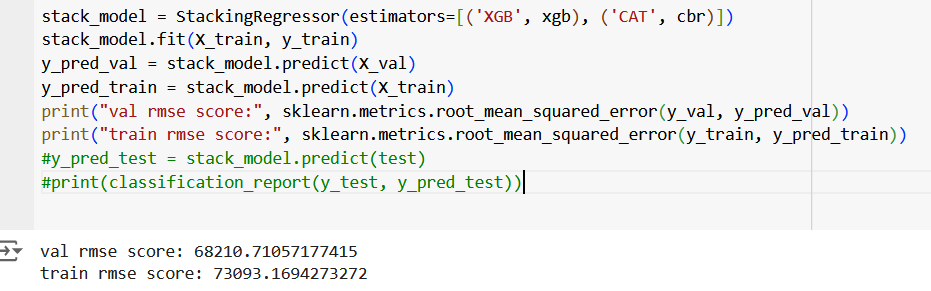

3 минуты лес и catboost

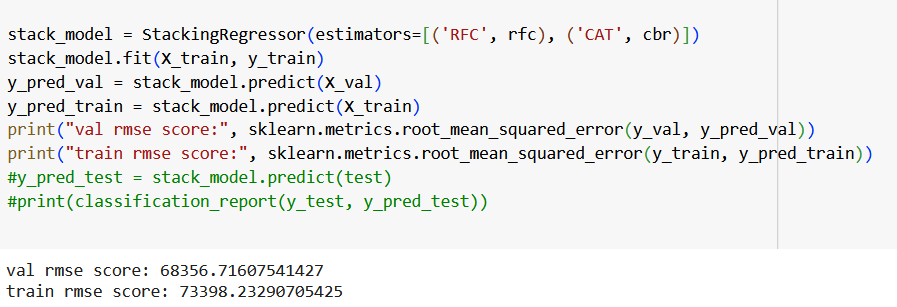

Проверка качества работы полученной модели

In [ ]:
test = df_encoded

In [ ]:
y_pred_test = stack_model.predict(X)

Сохранение результатов работы модели

In [ ]:
#prediction = pd.DataFrame(y_pred_test,
#                          columns=['price']).to_csv('prediction_on_car_price.csv')
prediction = pd.DataFrame({
    'price': y_pred_test
}, index = test['id']).reset_index()


prediction.to_csv('prediction_on_car_price.csv', index=False)